# **Negative News Neural Nets Project**
##Classifying Adverse Media Articles using Machine Learning Algorithms


---


Team: **P18**

Team Members:


* Kristjan Roosild
* Janberk Akhba
* Karl Hannes Veskus
* Villem-Oskar Ossip



---
Latest results:


*   F1 score for model on train  validation data: **95.24%**
*   F1 score for model on public validation data: **94.3%**




## Setup:
Here we will load necessary libraries (NumPy, Pandas, Spacy) and download necessary models (Keras BERT, Spacy LangDetect etc).

In [101]:
import spacy
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from wordcloud import WordCloud

from google.colab import drive, files
import glob
import os

!pip install keras-bert # https://pypi.org/project/keras-bert/#Download-Pretrained-Checkpoints

import keras
import keras_bert
from keras_bert import extract_embeddings, PretrainedList, get_pretrained

import tensorflow as tf
import tensorflow_hub as hub

import logging
logging.basicConfig(level=logging.INFO)

import tensorflow_hub as hub

!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece

import tokenization

from sklearn.model_selection import train_test_split

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

import seaborn as sns



---


## Setting up Google Colab


Lets give Collar access to your Google Drive:

In [59]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using `!ls` find the correct path to the project folder:

In [60]:
path = '/content/drive/MyDrive/Magister/Subjects/Machine Learning/ML2020-Uni-Project'
os.chdir(path)

In [61]:
!ls

 4N_P18.ipynb			      tokenization.py
 adverse_media_training.csv.zip       tokenization.py.1
 model-500len-public-test-93.h5       tokenization.py.2
 model.h5			      tokenization.py.3
 non_adverse_media_training.csv.zip   tokenization.py.4
 public_test.csv		     'Untitled presentation.gslides'




---


## Preprocessing

First, lets load in necessary CSV file:


1.   non_adverse_media_training.csv.zip
2.   adverse_media_training.csv.zip

These two zip files contain data from training our model. Data was hand picked - meaning articles from web were searched manually and labeld as NAM (non_adverse_media) or AM (adverse_media).


---






In [62]:
nam = pd.read_csv('non_adverse_media_training.csv.zip')
am = pd.read_csv('adverse_media_training.csv.zip')



---



In both CSV files each row represents one article and for each row we have 11 different columns.
Column meanings:


* **source** <- Individuals name who collected given article
* **entity_name** <- Searched entity name
* **entity_type** <- Organization, individual, company or NaN
* **url** <- Original source where the article was found
* **article** <- Content of the article
* **full_response** <- Web scraper was used to get the content of given page
* **label** <- Manually labeld article type (NAM, AM or NaN). NaN was used when there was uncertainty on how to label the article.
* **explanation** <- Some additional information why given article was labeld how ever it was labled
* **assessor** <- Name of the person who validated the article content and label
* **comment** <- If there were anything else to mention about the article
* **title** <- Title of the given article



In [63]:
#Example aritcle to get a better undestanding
am[8:9]

,source,entity_name,entity_type,url,article,full_response,label,explanation,assessor,comment,title
8,Canberk,Sam Waksal,Person,http://content.time.com/time/specials/packages...,"Bernie Madoff, who is scheduled to be sentence...","[{'error': 'Proxy error: msgtimeout', 'query':...",am,fraud,Carel,NaN,Top 10 Crooked CEOs


Now let us separate only the neccesary colums, combine the data into one collection, and covert it to binary labels. We only want to keep the article content, title and label.

In [64]:
# Keep only needed columns
am_cropped = am[['article','title','label']]
nam_cropped = nam[['article','title', 'label']]

# Combine source files and re-label to binary. We use number 1 as AM and 0 as NAM
am = pd.concat(
    [ am_cropped.loc[(am_cropped.label == 'am') | (am_cropped.label == 'am ')],
     nam_cropped.loc[(nam_cropped.label == 'am')] ]
)
am['label'] = 1

nam = pd.concat(
    [ am_cropped.loc[(am_cropped.label == 'nam')], 
     nam_cropped.loc[(nam_cropped.label == 'nam')] ]
)
nam['label'] = 0


# Combine data into one table
data = pd.concat([am,nam])

In [65]:
#Example print for better understaning
data[:2]

,article,title,label
8,"Bernie Madoff, who is scheduled to be sentence...",Top 10 Crooked CEOs,1
10,Published\n\nOne of the world's leading fund m...,Top fund manager forced to resign after BBC in...,1


In [66]:
len_am = len(am)
len_nam = len(nam)
total = len_am + len_nam
print("Total amount of article: ", total)
print(f"AM: {round(len_am/total * 100, 1)}%")
print(f"NAM: {round(len_nam/total * 100, 1)}%")
print('Ratio of AM to NAM articles:', round(len_am/len_nam, 2))

Total amount of article:  714
AM: 57.6%
NAM: 42.4%
Ratio of AM to NAM articles: 1.36




---


Now let us combine the article and title columns

In [67]:
def combine_columns(data):
  data["article"] = data["title"] + " " + data["article"]
  data = data.drop(["title"], axis =1)
  return data

In [68]:
data = combine_columns(data)
data[:2]

,article,label
8,"Top 10 Crooked CEOs Bernie Madoff, who is sche...",1
10,Top fund manager forced to resign after BBC in...,1


In [69]:
def wordcloud(data):
  text = ' '.join(data["article"].tolist())
  wordcloud = WordCloud().generate(text)
  wordcloud = WordCloud(max_font_size=40).generate(text)
  return wordcloud

In [70]:
def double_plot(wordcloud_1, wordcloud_2):
  plt.figure(figsize=(90,90))
  plt.subplot(1,2,1)
  plt.imshow(wordcloud_1)
  plt.subplot(1,2,2)
  plt.imshow(wordcloud_2)
  plt.axis("off")
  plt.show()

def plot(wordcloud):
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

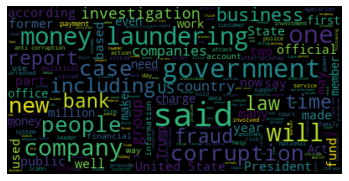

In [71]:
plot(wordcloud(data))

Lets load in Spacy English multi-task CNN trained on OntoNotes. 

In [72]:
nlp = spacy.load('en_core_web_sm')

Create two regexes to detect links, empty spaces and all sorts of other unneccasry noise in the article:

In [73]:
regex1 = re.compile(r'(http\S+)|(#(\w+))|(@(\w+))|[^\w\s]|(\w*\d\w*)')
regex2 = re.compile(r'(\s+)|(\n+)')

We use **lemmatize** function to remove unneccasary noise, and lemmatize the from each article.  

In [74]:
def lemmatize(article):
    article = re.sub(regex1, '', article)
    article = re.sub(regex2,' ', article).strip().lower()
    
    doc = nlp(article)
    lemmatized_article = " ".join([token.lemma_ for token in doc if (token.is_stop==False)]) 
    
    return lemmatized_article

Lemmatizing the whole dataset:

In [75]:
def lemmatize_articles(data):
  train = data[['article', 'label']].copy()
  train["article"] = train["article"].apply(lemmatize)
  train = train.reset_index()
  lemmatized_articles = train.drop(['index'], axis=1)
  return lemmatized_articles

In [76]:
%%time
lemmatized_articles = lemmatize_articles(data)

CPU times: user 1min 11s, sys: 739 ms, total: 1min 12s
Wall time: 1min 12s


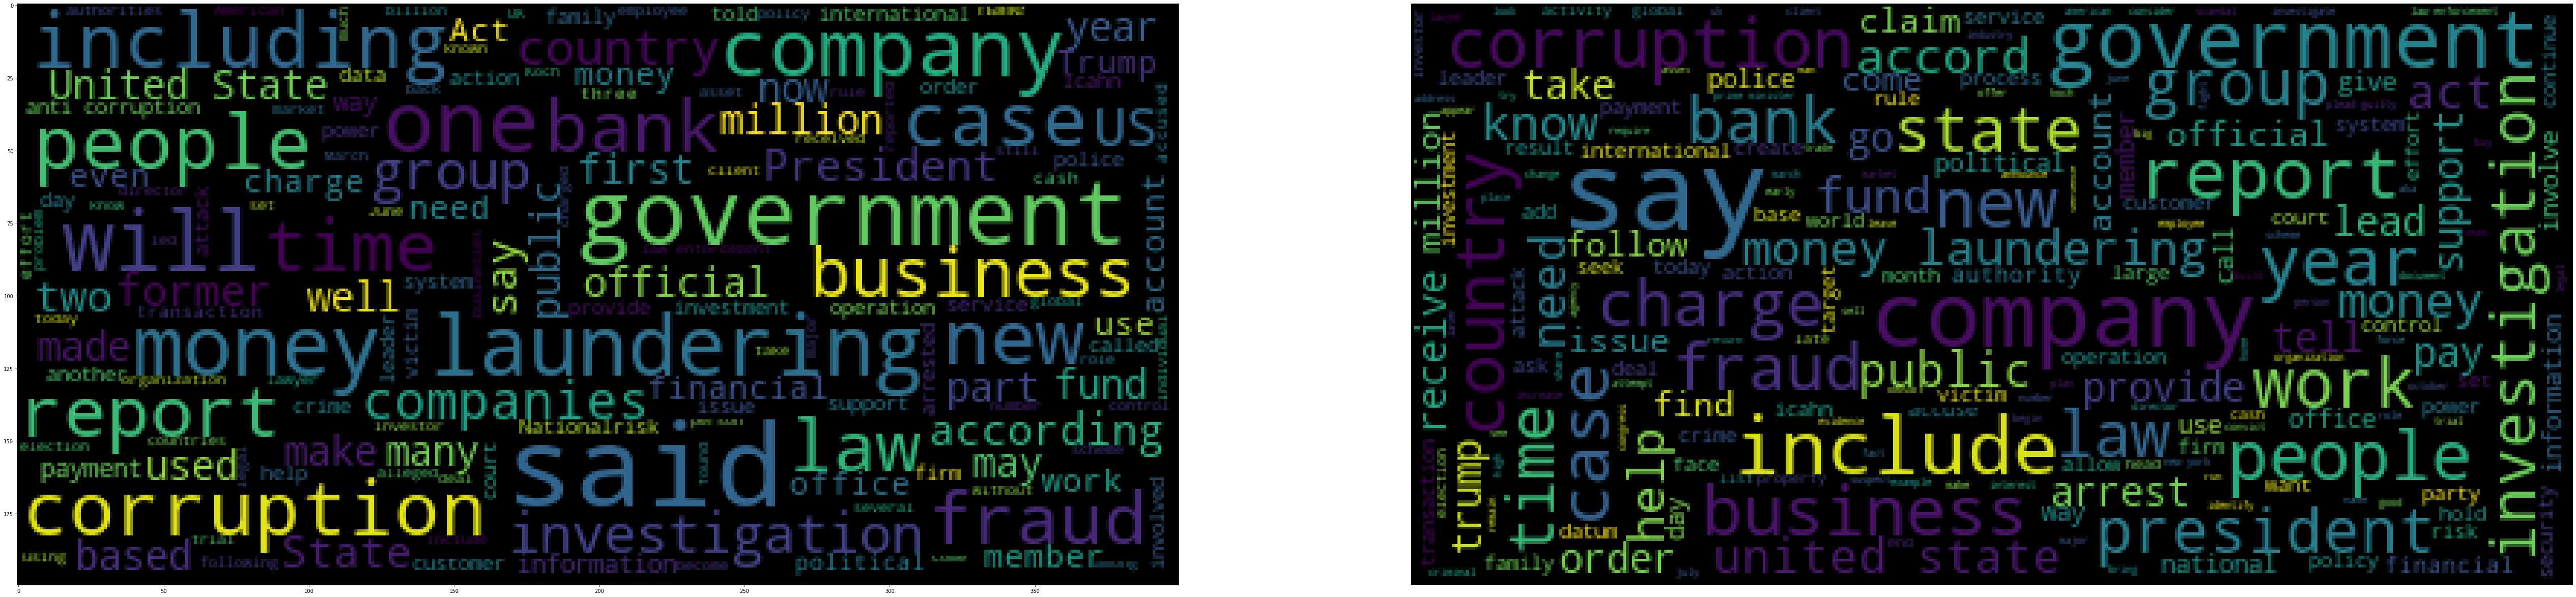

In [77]:
#Plot before and after data (left side is before, right side is after lemmatization)
double_plot(wordcloud(data), wordcloud(lemmatized_articles))

Example to get a better understanding on an article before and after lemmatization:

In [78]:
def before_and_after_lemmatization(data):
  before = data.article[8]
  lemmatized = lemmatize(before)

  print('Before Lemmatization:', before[:80])
  print("#############")
  print('After Lemmatization:', lemmatized[:80])

In [79]:
before_and_after_lemmatization(data)

Before Lemmatization: Top 10 Crooked CEOs Bernie Madoff, who is scheduled to be sentenced June 29 for 
#############
After Lemmatization: crooked ceos bernie madoff schedule sentence june perpetrate historys big ponzi 




---


## Test and train data

Now lets used the previously lemmatized articles to create train and validation sets. Lets use 10% of data for test/validation.

In [80]:
bert_train = lemmatized_articles.sample(frac = 1) 

x_train, x_val, y_train, y_val = train_test_split(bert_train['article'], 
                                                    bert_train['label'], 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    stratify= bert_train['label'])

print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

(642,) (72,) (642,) (72,)




---


## BERT and Keras

BERT (Bidirectional Encoder Representations from Transformers) is a model that knows to represent text. You give it some sequence as an input, it then looks left and right several times and produces a vector representation for each word as the output.

In order to build a well performing models, deep learning-based NLP models require much larger amounts of data. In our case we have only few hundred human labled data sets, so we decided to use pre-trained model (bert_en_uncased_L-12_H-768_A-12) to fine-tune on our smaller task-specific dataset. 

### Build a BERT Layer

In [81]:
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:resolver HttpCompressedFileResolver does not support the provided handle.
INFO:absl:resolver GcsCompressedFileResolver does not support the provided handle.


### Encoding the raw text

Let create a tokenizer, which we will be using later. Tokenization is a process to take raw texts and split into tokens, which are numeric data to represent words.

In [82]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

Creating encoder function for BERT:

In [83]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            

        # TODO: Should be changed to split the text into chunks, process each chunk separately, and later combine
        text = text[:max_len-2]



        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

Creating model building function which takes in bert_layer and number of tokens (max 512):

In [84]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(2, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

Now let use our bert encoder to get tokens, masks and segments for our train and test data:

In [85]:
%%time
max_len = 500 #Maximum length of the sequence for BERT is 512 tokens
train_input = bert_encode(x_train, tokenizer, max_len=max_len)
test_input = bert_encode(x_val, tokenizer, max_len=max_len)
train_labels =keras.utils.to_categorical(y_train, num_classes=2)

CPU times: user 5.11 s, sys: 4.65 ms, total: 5.12 s
Wall time: 5.11 s


Let actually now build our model:

In [86]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 500)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 500)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 500)]        0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

### Run the model

Lets load in keras checkpoints an earlystopping. Fit our model with 20% split of validation set, with 8 epochs and batch size of 8. 

Skip the following step as we will be loading in pre-trained model instead. But if you want to re-train it, then your are welcome to do it:

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=10,
    callbacks=[checkpoint, earlystopping],
    batch_size=8,
    verbose=1)

##Pre-trained model

Lets load in our pre-trained model and predict it on our BERT encoded x_val data:

In [87]:
model.load_weights('model-500len-public-test-93.h5')
test_pred = model.predict(test_input)

Lets check that our test prediction and validation sets have same shapes:

In [88]:
print("Test pred shape: ", test_pred.shape)
print("Test validation shape: ", y_val.shape)

Test pred shape:  (72, 2)
Test validation shape:  (72,)


Now lets change our prediction set probabilities to binary:

In [89]:
def prob_to_bin(pred):
  return [1 if el[1]> 0.5 else 0 for el in pred]

In [90]:
pred = prob_to_bin(test_pred)

Predict with the model:

In [91]:
def f1(y_val, pred):
  val_f1_score = f1_score(y_val, pred)
  print(f"F1 score for model on validation data: {round(val_f1_score * 100, 2)}%")

In [92]:
f1(y_val, pred)

F1 score for model on validation data: 97.56%


##Pre-trained model - Public Test

Load in public test csv file, combine columns and lemmatize each article:

In [93]:
%%time
public_test = combine_columns(pd.read_csv('public_test.csv'))
public_test_lemmatized = lemmatize_articles(public_test)

CPU times: user 15.1 s, sys: 280 ms, total: 15.4 s
Wall time: 15.4 s


In [94]:
before_and_after_lemmatization(public_test)

Before Lemmatization: Rev. Jeremiah Wright's Daughter Indicted for Alleged Money Laundering April 11, 
#############
After Lemmatization: rev jeremiah wrights daughter indict alleged money launder april daughter rev je


Create BERT encoded/tokenized public test set:

In [95]:
public_test_tokenized = bert_encode(public_test_lemmatized['article'], tokenizer, max_len=max_len)
public_test_pred = model.predict(public_test_tokenized)

Predict with the model:

In [96]:
public_test_pred = prob_to_bin(public_test_pred)
f1(public_test_lemmatized['label'], public_test_pred)

F1 score for model on validation data: 94.3%


###AUC

To evaluate the model, we calculate the AUC (Area under the ROC Curve) for the model below.

In [105]:
auc_lstm = roc_auc_score(public_test_lemmatized['label'], public_test_pred)
print(f"AUC score for model on public data: {round(auc_lstm * 100, 2)}%")

AUC score for model on public data: 92.87%


###Evaluating the Performance: Visualization

We can also visualize the classifications in binary.

In [99]:
df_pred = pd.DataFrame(data={'y_actual': public_test_lemmatized['label'], 'y_pred': public_test_pred})

We can see that the majority of AM (orange) has y_pred value of 1; and AM (blue) has y_pred of 0. Also we can see that some AM were predicted as NAM and vise versa.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


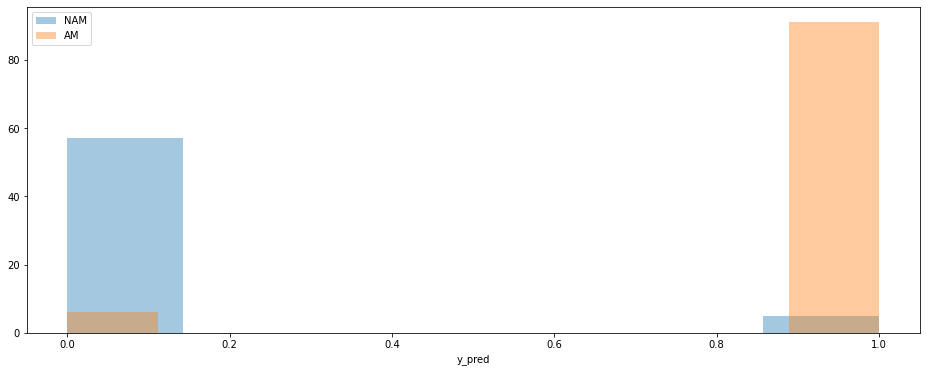

In [104]:
plt.figure(figsize=(16, 6))

msk = df_pred['y_actual'] == 0
sns.distplot(df_pred.loc[msk, 'y_pred'], label='NAM', kde=False)
sns.distplot(df_pred.loc[~msk, 'y_pred'], label='AM', kde=False)
plt.legend()

##Logit Predict Probabilities For Data Cleanup

In [107]:
data.shape

(714, 2)